In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error

import data_utils.data_analysis as data_analysis
import models.tools as models_tools
import models.rf as rf

In [2]:
#get the shot number from the test index
#(potential bug: pass the right df_input that has been used to create y_test. For example: df_input_clean)
def get_shot_num(shot_index,y_test,df_input):
    id_value=y_test.iloc[shot_index].name
    return(df_input['shot number'].loc[id_value])

In [3]:
#get the spectral coeeficients (as in the get shot num)
def get_coef(shot_index,y_test,df_input):
    id_value=y_test.iloc[shot_index].name
    order2=df_input['order2'].loc[id_value]
    order3=df_input['order3'].loc[id_value]
    order4=df_input['order4'].loc[id_value]
    return order2, order3, order4

In [4]:
filename='datasets/galadriel_dataset_24_06_28.h5'
df_input,df_time_val,df_time,df_freq_val,df_freq_int = data_analysis.read_dataset(filename)

Input DF
       shot number  order2  order3     order4
0           136497   34900  -17000 -4600000.0
1           136498   34900  -17000 -4600000.0
2           136499   34900  -17000 -4600000.0
3           136500   34900  -17000 -4500000.0
4           136501   34900  -17000 -4500000.0
...            ...     ...     ...        ...
15503       152002   35400   29000 -3800000.0
15504       152003   35400   29000 -3800000.0
15505       152004   35400   29000 -3700000.0
15506       152005   35400   29000 -3700000.0
15507       152006   35400   29000 -3700000.0

[15508 rows x 4 columns]
----
Time values
0    -115.458450
1    -104.962227
2     -94.466005
3     -83.969782
4     -73.473559
5     -62.977336
6     -52.481114
7     -41.984891
8     -31.488668
9     -20.992445
10    -10.496223
11      0.000000
12     10.496223
13     20.992445
14     31.488668
15     41.984891
16     52.481114
17     62.977336
18     73.473559
19     83.969782
20     94.466005
21    104.962227
Name: 0, dtype: float6

In [5]:
def train_forward(df_input,df_time):
    #split the dataset (X:dazzler param, Y:wizzler)
    X_train, X_test, y_train, y_test=models_tools.split_dataset_roundtrip(df_input,df_time,rand_split=False)
    #Reset the index on y_test to have the same indexes as y_predict
    y_test_reset=y_test.reset_index(drop=True)

    #train forward model with Random forest
    n_estimators = 300
    max_features = 'sqrt'
    max_depth=20
    random_state=18

    forward_model_rf=rf.fit_random_forest(X_train,y_train,n_estimators, max_features,max_depth, random_state=18)

    y_predict_forward=rf.make_rf_prediction(forward_model_rf,X_test)

    #study the erro distribution
    df_error_forward_rf=abs(y_test_reset-y_predict_forward)
    df_error_forward_rf=df_error_forward_rf.sum(axis=1)/y_test.shape[1] #sum error / num columns

    return forward_model_rf,df_error_forward_rf


In [6]:
#split the dataset (X:dazzler param, Y:wizzler)
X_train, X_test, y_train, y_test=models_tools.split_dataset_roundtrip(df_input,df_time,rand_split=False)
#Reset the index on y_test to have the same indexes as y_predict
y_test_reset=y_test.reset_index(drop=True)

In [7]:
forward_model_rf,df_error_forward_rf=train_forward(df_input,df_time)

In [8]:
y_predict_forward=rf.make_rf_prediction(forward_model_rf,X_test)

### Plot a prediction

In [9]:
def plot_example(shot_index,y_test,y_test_reset,df_input,df_time_val,
                 y_predict_forward):
    #shot_index= is not the actual shot number but the index on the test set
    shot_numb=get_shot_num(shot_index,y_test,df_input)
    order2,order3,order4=get_coef(shot_index,y_test,df_input)
    
    plt.plot(df_time_val,y_test_reset.loc[shot_index],label='Test (shot #'+str(shot_numb)+')',linewidth=3)
    #plt.plot(df_time_val,y_predict_lin_backforw[shot_index],label='Prediction (Linear)')
    plt.plot(df_time_val,y_predict_forward[shot_index],label='Prediction (Random  Forest)',linewidth=3,linestyle='--')

    mae='{:6.2f}'.format(100*mean_absolute_error(y_test_reset.loc[shot_index],y_predict_forward[shot_index]))
    plt.title('Mean abs. error:'+mae+'%',fontsize=14)
    plt.text(35, 0.7, r'$\beta^2=$'+str(order2), dict(size=14))
    plt.text(35, 0.6, r'$\beta^3=$'+str(order3), dict(size=14))
    plt.text(35, 0.5, r'$\beta^4=$'+str(order4), dict(size=14))
    plt.xlabel('Time(fs)',fontsize=14)
    plt.ylabel('Intensity',fontsize=14)
    plt.legend()

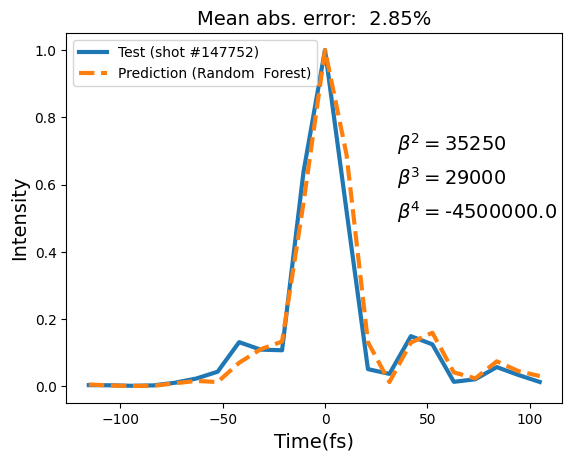

In [10]:
shot_index=1359#25
plot_example(shot_index,y_test,y_test_reset,df_input,df_time_val,y_predict_forward)

## ACCURACY different ML models

## MAE in the paramter space

In [11]:
temp_error_forest=df_error_forward_rf.copy()
temp_error_forest.to_frame()
temp_error_forest=temp_error_forest.set_axis(y_test.index)
print(temp_error_forest)
df_error_distr=X_test.copy()
df_error_distr['error prediction']=temp_error_forest
df_error_distr=df_error_distr[df_error_distr['error prediction']>0.01]
df_error_distr

7202     0.004292
11746    0.014711
12657    0.019587
8926     0.039631
7519     0.035387
           ...   
5157     0.002514
13052    0.005667
12560    0.036099
2950     0.003644
13410    0.015799
Length: 4653, dtype: float64


,order2,order3,order4,error prediction
11746,35300,-2000,-4000000.0,0.014711
12657,35300,28000,-3700000.0,0.019587
8926,35200,-2000,-4100000.0,0.039631
7519,35150,-2000,-4000000.0,0.035387
9141,35200,5000,-3900000.0,0.177032
...,...,...,...,...
8755,35200,-8000,-3800000.0,0.054917
13007,35350,-7000,-4000000.0,0.023302
13948,35350,24000,-3600000.0,0.080800
12560,35300,25000,-3900000.0,0.036099


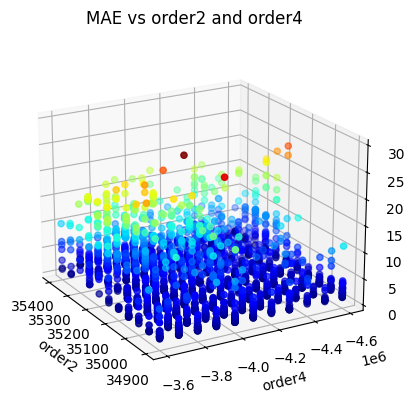

In [173]:
fig = plt.figure()
ax3 = fig.add_subplot(projection='3d')
ax3.scatter(df_error_distr['order2'], df_error_distr['order4'], 100*df_error_distr['error prediction'],c=100*df_error_distr['error prediction'],cmap='jet')
ax3.set_xlabel('order2')
ax3.set_ylabel('order4')
ax3.set_zlabel('Error')
ax3.view_init(elev=20., azim=150)
plt.title('MAE vs order2 and order4')
plt.show()

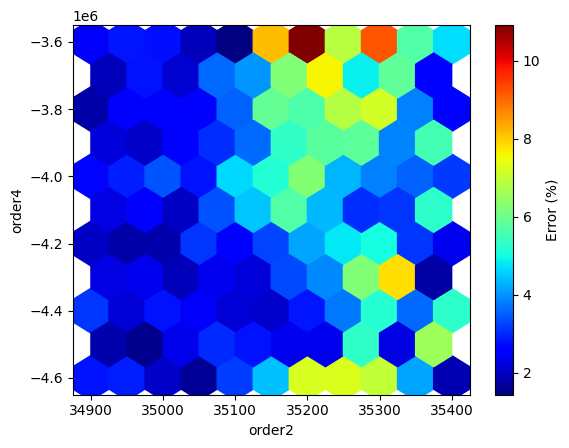

In [206]:
fig, ax = plt.subplots()
h1=ax.hexbin(df_error_distr['order2'], df_error_distr['order4'], C=100*df_error_distr['error prediction']
             ,gridsize=10,cmap='jet')
ax.set_xlabel('order2')
ax.set_ylabel('order4')
cbar =fig.colorbar(h1, ax=ax)
cbar.set_label('Error (%)')

## ACCURACY VS DATASET SIZE

In [13]:
def drop_shots(drop_factor,df_input,df_time,df_freq_int):
    remove_n = int(drop_factor*len(df_input)) #number of shots to be dropped
    #print(remove_n)
    drop_indices = np.random.choice(df_input.index, remove_n, replace=False)
    df_input_subset = df_input.drop(drop_indices)
    df_time_subset = df_time.drop(drop_indices)
    df_freq_int_subset = df_freq_int.drop(drop_indices)
    #print(df_input_subset)
    #print(df_time_subset)
    print('The datasize is : '+str(len(df_time_subset)))
    return df_input_subset,df_time_subset,df_freq_int_subset

In [14]:
drop_factor=0.00
df_input_subset_15k,df_time_subset_15k,df_freq_int_subset_15k=drop_shots(drop_factor,df_input,df_time,df_freq_int)

drop_factor=0.50
df_input_subset_7k,df_time_subset_7k,df_freq_int_subset_7k=drop_shots(drop_factor,df_input,df_time,df_freq_int)

drop_factor=0.70
df_input_subset_4k,df_time_subset_4k,df_freq_int_subset_4k=drop_shots(drop_factor,df_input,df_time,df_freq_int)

drop_factor=0.90
df_input_subset_1500,df_time_subset_1500,df_freq_int_subset_1500=drop_shots(drop_factor,df_input,df_time,df_freq_int)

drop_factor=0.95
df_input_subset_700,df_time_subset_700,df_freq_int_subset_700=drop_shots(drop_factor,df_input,df_time,df_freq_int)

drop_factor=0.975
df_input_subset_300,df_time_subset_300,df_freq_int_subset_300=drop_shots(drop_factor,df_input,df_time,df_freq_int)


The datasize is : 15508
The datasize is : 7754
The datasize is : 4653
The datasize is : 1551
The datasize is : 776
The datasize is : 388


**Train the models**

In [15]:
#15000 dataset
forward_model_rf_15k,df_error_forward_rf_15k=train_forward(df_input_subset_15k,df_time_subset_15k)

#7000 dataset
forward_model_rf_7k,df_error_forward_rf_7k=train_forward(df_input_subset_7k,df_time_subset_7k)

#4000 dataset
forward_model_rf_4k,df_error_forward_rf_4k=train_forward(df_input_subset_4k,df_time_subset_4k)

#71500 dataset
forward_model_rf_1500,df_error_forward_rf_1500=train_forward(df_input_subset_1500,df_time_subset_1500)

#700 dataset
forward_model_rf_700,df_error_forward_rf_700=train_forward(df_input_subset_700,df_time_subset_700)

#300 dataset
forward_model_rf_300,df_error_forward_rf_300=train_forward(df_input_subset_300,df_time_subset_300)

**NOTE**:The following error in on the subset (NOT the whole experimental dataset)

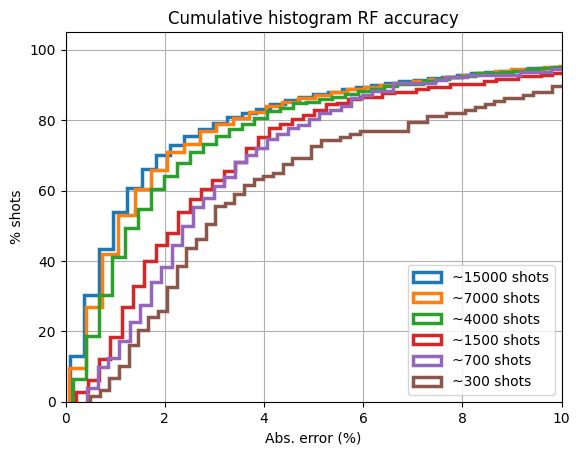

In [36]:
weights_forward_15k = 100*np.ones_like(df_error_forward_rf_15k) / len(df_error_forward_rf_15k)
weights_forward_7k = 100*np.ones_like(df_error_forward_rf_7k) / len(df_error_forward_rf_7k)
weights_forward_4k = 100*np.ones_like(df_error_forward_rf_4k) / len(df_error_forward_rf_4k)
weights_forward_1500 = 100*np.ones_like(df_error_forward_rf_1500) / len(df_error_forward_rf_1500)
weights_forward_700 = 100*np.ones_like(df_error_forward_rf_700) / len(df_error_forward_rf_700)
weights_forward_300 = 100*np.ones_like(df_error_forward_rf_300) / len(df_error_forward_rf_300)
(100*df_error_forward_rf_15k).hist(bins=100,weights=weights_forward_15k,cumulative=True,histtype="step",linewidth=2.5,label='~15000 shots')
(100*df_error_forward_rf_7k).hist(bins=100,weights=weights_forward_7k,cumulative=True,histtype="step",linewidth=2.5,label='~7000 shots')
(100*df_error_forward_rf_4k).hist(bins=100,weights=weights_forward_4k,cumulative=True,histtype="step",linewidth=2.5,label='~4000 shots')
(100*df_error_forward_rf_1500).hist(bins=100,weights=weights_forward_1500,cumulative=True,histtype="step",linewidth=2.5,label='~1500 shots')
(100*df_error_forward_rf_700).hist(bins=100,weights=weights_forward_700,cumulative=True,histtype="step",linewidth=2.5,label='~700 shots')
(100*df_error_forward_rf_300).hist(bins=100,weights=weights_forward_300,cumulative=True,histtype="step",linewidth=2.5,label='~300 shots')


plt.ylabel('% shots')
plt.xlabel('Abs. error (%)')
plt.title('Cumulative histogram RF accuracy')
plt.xlim(0,10)
plt.legend()
plt.show()

### Error in the whole dataset

In [25]:
def error_cal(forward_model_rf,X_test,y_test):
    y_test_reset=y_test.reset_index(drop=True)
    
    y_predict_forward=rf.make_rf_prediction(forward_model_rf,X_test)

    #study the error distribution
    df_error_forward_rf=abs(y_test_reset-y_predict_forward)
    df_error_forward_rf=df_error_forward_rf.sum(axis=1)/y_test.shape[1] #sum error / num columns
    return df_error_forward_rf

In [170]:
#calculate the error. 
# VERIFY that X_test and y_test are from the whole dataset
df_error_forward_15k_whole=error_cal(forward_model_rf_15k,X_test,y_test)
df_error_forward_7k_whole=error_cal(forward_model_rf_7k,X_test,y_test)
df_error_forward_4k_whole=error_cal(forward_model_rf_4k,X_test,y_test)
df_error_forward_1500_whole=error_cal(forward_model_rf_1500,X_test,y_test)
df_error_forward_700_whole=error_cal(forward_model_rf_700,X_test,y_test)
df_error_forward_300_whole=error_cal(forward_model_rf_300,X_test,y_test)

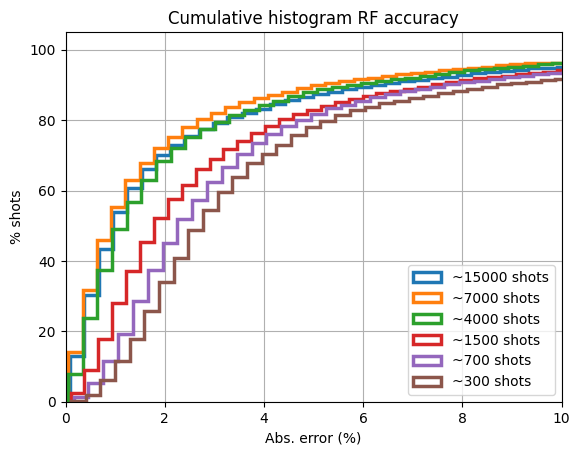

In [171]:
weights_forward_15k = 100*np.ones_like(df_error_forward_15k_whole) / len(df_error_forward_15k_whole)
weights_forward_7k = 100*np.ones_like(df_error_forward_7k_whole) / len(df_error_forward_7k_whole)
weights_forward_4k = 100*np.ones_like(df_error_forward_4k_whole) / len(df_error_forward_4k_whole)
weights_forward_1500 = 100*np.ones_like(df_error_forward_1500_whole) / len(df_error_forward_1500_whole)
weights_forward_700 = 100*np.ones_like(df_error_forward_1500_whole) / len(df_error_forward_700_whole)
weights_forward_300 = 100*np.ones_like(df_error_forward_300_whole) / len(df_error_forward_300_whole)
(100*df_error_forward_15k_whole).hist(bins=100,weights=weights_forward_15k,cumulative=True,histtype="step",linewidth=2.5,label='~15000 shots')
(100*df_error_forward_7k_whole).hist(bins=100,weights=weights_forward_7k,cumulative=True,histtype="step",linewidth=2.5,label='~7000 shots')
(100*df_error_forward_4k_whole).hist(bins=100,weights=weights_forward_4k,cumulative=True,histtype="step",linewidth=2.5,label='~4000 shots')
(100*df_error_forward_1500_whole).hist(bins=100,weights=weights_forward_1500,cumulative=True,histtype="step",linewidth=2.5,label='~1500 shots')
(100*df_error_forward_700_whole).hist(bins=100,weights=weights_forward_700,cumulative=True,histtype="step",linewidth=2.5,label='~700 shots')
(100*df_error_forward_300_whole).hist(bins=100,weights=weights_forward_300,cumulative=True,histtype="step",linewidth=2.5,label='~300 shots')


plt.ylabel('% shots')
plt.xlabel('Abs. error (%)')
plt.title('Cumulative histogram RF accuracy')
plt.xlim(0,10)
plt.legend()
plt.show()

In [145]:
#exploring boxplots

Text(0.5, 1.0, 'Histogram RF accuracy')

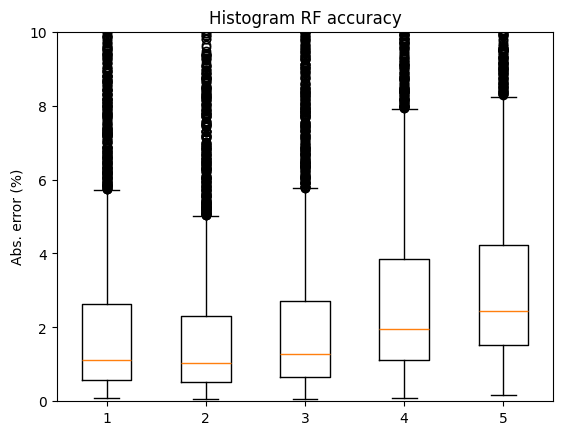

In [169]:
error_dist=[100*df_error_forward_15k_whole,
            100*df_error_forward_7k_whole,
            100*df_error_forward_4k_whole,
           100*df_error_forward_1500_whole,
           100*df_error_forward_700_whole]
plt.boxplot(error_dist)
#plt.boxplot(df_error_forward_7k_whole)
#plt.boxplot(df_error_forward_4k_whole)
plt.ylim(0,10)
plt.ylabel('Abs. error (%)')
plt.title('Histogram RF accuracy')

### Prediction of a shot (with different size of training data)

In [105]:
#returns the first shot index (NOT the shot number) given a set of imputs
def get_row_shot(df_input,order2,order3,order4):
    df_testing=df_input[(df_input['order2']==order2_in) & (df_input['order3']==order3_in)& (df_input['order4']==order4_in)]
    return df_testing.index.values[0]

In [121]:
def get_shot_from_index(shot_index,df_input):
    return df_input['shot number'].iloc[shot_index]

In [117]:
order2_in=34900
order3_in=13000
order4_in=-4300000
df_good_shots=df_input[(df_input['order2']==order2_in) & (df_input['order3']==order3_in)& (df_input['order4']==order4_in)]
X_good_shot=df_good_shots[['order2','order3','order4']]
print(X_good_shot)

     order2  order3     order4
909   34900   13000 -4300000.0
910   34900   13000 -4300000.0
911   34900   13000 -4300000.0


In [119]:
#get the index shot
good_shot_index=get_row_shot(df_input,order2_in,order3_in,order4_in)

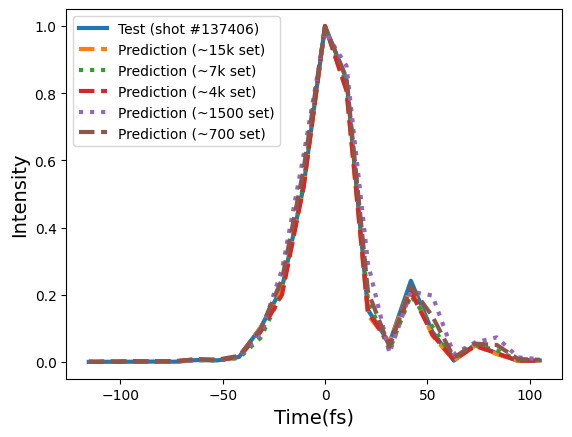

In [144]:
#plot
shot_numb=get_shot_from_index(good_shot_index,df_input)
plt.plot(df_time_val,df_time.iloc[good_shot_index],label='Test (shot #'+str(shot_numb)+')',linewidth=3)
plt.plot(df_time_val,y_predict_good_shot_15k[0],label='Prediction (~15k set)',linewidth=3,linestyle='--')
plt.plot(df_time_val,y_predict_good_shot_7k[0],label='Prediction (~7k set)',linewidth=3,linestyle=':')
plt.plot(df_time_val,y_predict_good_shot_4k[0],label='Prediction (~4k set)',linewidth=3,linestyle='--')
plt.plot(df_time_val,y_predict_good_shot_1500[0],label='Prediction (~1500 set)',linewidth=3,linestyle=':')
plt.plot(df_time_val,y_predict_good_shot_700[0],label='Prediction (~700 set)',linewidth=3,linestyle='--')
plt.xlabel('Time(fs)',fontsize=14)
plt.ylabel('Intensity',fontsize=14)
plt.legend()

In [82]:
y_predict_good_shot_15k=rf.make_rf_prediction(forward_model_rf_15k,X_good_shot)
y_predict_good_shot_7k=rf.make_rf_prediction(forward_model_rf_7k,X_good_shot)
y_predict_good_shot_4k=rf.make_rf_prediction(forward_model_rf_4k,X_good_shot)
y_predict_good_shot_1500=rf.make_rf_prediction(forward_model_rf_1500,X_good_shot)
y_predict_good_shot_700=rf.make_rf_prediction(forward_model_rf_700,X_good_shot)

**Check if the dazzler values were on the training data**

In [139]:
def check_if_present(df_input,order2,order3,order4):
    df_testing=df_input[(df_input['order2']==order2_in) & (df_input['order3']==order3_in)& (df_input['order4']==order4_in)]
    if df_testing.empty:
        print('Not in the dataset')
    else:
        print("it's present")

In [140]:
check_if_present(df_input_subset_15k,order2_in,order3_in,order4_in)
check_if_present(df_input_subset_7k,order2_in,order3_in,order4_in)
check_if_present(df_input_subset_4k,order2_in,order3_in,order4_in)
check_if_present(df_input_subset_1500,order2_in,order3_in,order4_in)
check_if_present(df_input_subset_700,order2_in,order3_in,order4_in)

it's present
Not in the dataset
it's present
Not in the dataset
it's present


# Different days

In [17]:
#READ THE DATASET
#240314
filename='datasets/galadriel_dataset_24_03_14.h5'
df_input_240314,df_time_val_240314,df_time_240314,df_freq_val_240314,df_freq_int_240314 = data_analysis.read_dataset(filename)

filename='datasets/galadriel_dataset_24_04_11.h5'
df_input_240411,df_time_val_240411,df_time_240411,df_freq_val_240411,df_freq_int_240411 = data_analysis.read_dataset(filename)

filename='datasets/galadriel_dataset_24_05_09.h5'
df_input_240509,df_time_val_240509,df_time_240509,df_freq_val_240509,df_freq_int_240509 = data_analysis.read_dataset(filename)

#READ THE DATASET 24_06_28
filename='datasets/galadriel_dataset_24_06_28.h5'
df_input_240628,df_time_val_240628,df_time_240628,df_freq_val_240628,df_freq_int_240628 = data_analysis.read_dataset(filename)


Input DF
       shot number  order2  order3     order4
0             4731   34900  -17000 -3700000.0
1             4733   34900  -17000 -4600000.0
2             4734   34900  -17000 -4600000.0
3             4735   34900  -17000 -4600000.0
4             4736   34900  -17000 -4500000.0
...            ...     ...     ...        ...
12156        17147   35300   20000 -3800000.0
12157        17148   35300   20000 -3800000.0
12158        17149   35300   20000 -3800000.0
12159        17150   35300   20000 -3700000.0
12160        17151   35300   20000 -3700000.0

[12161 rows x 4 columns]
----
Time values
0    -94.466005
1    -83.969782
2    -73.473559
3    -62.977336
4    -52.481114
5    -41.984891
6    -31.488668
7    -20.992445
8    -10.496223
9      0.000000
10    10.496223
11    20.992445
12    31.488668
13    41.984891
14    52.481114
15    62.977336
16    73.473559
17    83.969782
18    94.466005
Name: 0, dtype: float64
----
Intensity
             0         1         2         3         

In [18]:
forward_model_rf_240314,df_error_forward_rf_240314=train_forward(df_input_240314,df_time_240314)

forward_model_rf_240411,df_error_forward_rf_240411=train_forward(df_input_240411,df_time_240411)

forward_model_rf_240509,df_error_forward_rf_240509=train_forward(df_input_240509,df_time_240509)

forward_model_rf_240628,df_error_forward_rf_240628=train_forward(df_input_240628,df_time_240628)

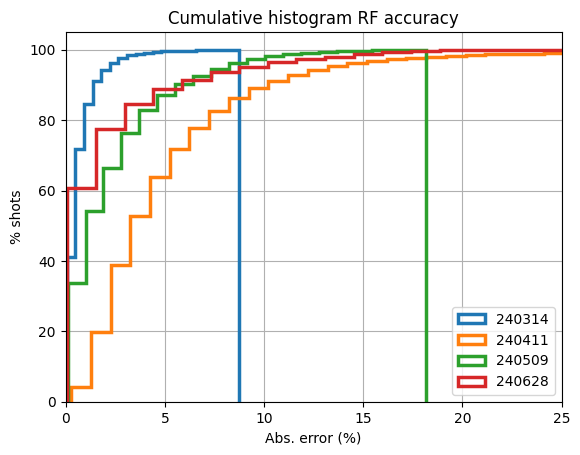

In [19]:
weights_240314 = 100*np.ones_like(df_error_forward_rf_240314) / len(df_error_forward_rf_240314)
weights_240411 = 100*np.ones_like(df_error_forward_rf_240411) / len(df_error_forward_rf_240411)
weights_240509 = 100*np.ones_like(df_error_forward_rf_240509) / len(df_error_forward_rf_240509)
weights_240628 = 100*np.ones_like(df_error_forward_rf_240628) / len(df_error_forward_rf_240628)
(100*df_error_forward_rf_240314).hist(bins=20,weights=weights_240314,cumulative=True,histtype="step",linewidth=2.5,label='240314')
(100*df_error_forward_rf_240411).hist(bins=40,weights=weights_240411,cumulative=True,histtype="step",linewidth=2.5,label='240411')
(100*df_error_forward_rf_240509).hist(bins=20,weights=weights_240509,cumulative=True,histtype="step",linewidth=2.5,label='240509')
(100*df_error_forward_rf_240628).hist(bins=20,weights=weights_240628,cumulative=True,histtype="step",linewidth=2.5,label='240628')

plt.ylabel('% shots')
plt.xlabel('Abs. error (%)')
plt.title('Cumulative histogram RF accuracy')
plt.xlim(0,25)
plt.legend()
plt.show()

# Predictions without training (using 240314 training)
### TODO: pulse shape have different size

In [20]:
def error_dist(y_prediction,y_test):
    df_aux=abs(y_test-y_prediction)
    df_error=df_aux.sum(axis=1)/y_test.shape[1] #sum error / num columns
    return df_error

In [21]:
#240411
#split the dataset (X:dazzler param, Y:wizzler)
X_train_240411, X_test_240411, y_train_240411, y_test_240411=models_tools.split_dataset_roundtrip(df_input_240411,df_time_240411,rand_split=False)
y_test_reset_240411=y_test_240411.reset_index(drop=True)
X_train_240628, X_test_240628, y_train_240628, y_test_240628=models_tools.split_dataset_roundtrip(df_input_240628,df_time_240628,rand_split=False)
y_test_reset_240628=y_test_240628.reset_index(drop=True)

In [22]:
#make the predictions using the old models
y_predict_old_240411=rf.make_rf_prediction(forward_model_rf_240314,X_test_240411)
y_predict_old_240628=rf.make_rf_prediction(forward_model_rf_240314,X_test_240628)

In [23]:
print(len(y_train_240411.columns))
print(len(y_train_240628.columns))
print(len(df_time_240314.columns))

18
22
19


In [24]:
df_error_old_240411=error_dist(y_predict_old_240411,y_test_reset_240411)
df_error_old_240628=error_dist(y_predict_old_240628,y_test_reset_240628)

ValueError: Unable to coerce to DataFrame, shape must be (4653, 18): given (4653, 19)